Testbed for LSTM

In [ ]:
import numpy as NP
import pickle
import matplotlib.pyplot as PLT
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho
from Neural_Decoding.decoders import LSTMDecoder
import sklearn
from matplotlib import pyplot as PLT
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
Training_range=[0, 0.5]
Valid_range=[0.5,0.65]
Testing_range=[0.65, 0.8]
lag=0

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=6 #How many bins of neural data after the output are used for decoding

File=open("data/example_data_s1.pickle",mode='rb')
[neural_data,pos_binned]=pickle.load(File,)
print(f"neural_data \n{NP.shape(neural_data)}"+"\n"+f"pos_binned \n{NP.shape(pos_binned)}")

"""
neural_data:    When neurons Fired. num_bins x num_neurons. 1 when fired, 0 when not.
pos_binned       :    X and Y velocities
"""

#Remove all rows of pos binned and neural data where pos binned is NaN
rmv_time=NP.where(NP.isnan(pos_binned[:,0]) | NP.isnan(pos_binned[:,1]))
X=NP.delete(neural_data,rmv_time,0)
pos_binned=NP.delete(pos_binned,rmv_time,0)

#get velocity of positions binned
temp=NP.diff(pos_binned,axis=0)
vels_binned=NP.concatenate((temp,temp[-1:,:]),axis=0)

#We now determine acceleration, by taking diff between each position.
temp2=NP.diff(vels_binned,axis=0)

#Y is the positions binned, velocities binned, then acc_binned in numpy array.
Y=(vels_binned)

nd_sum=NP.nansum(X,axis=0) #Total number of spikes of each neuron


rmv_nrn=NP.where(nd_sum<100) #Find neurons who have less than 100 spikes total
rmv_nrn_std=NP.where(nd_sum<nd_thresh) #Find neurons who have less than 2 std of dataset. Gerrik
print(f"rmv_nrn \n{NP.shape(rmv_nrn)}"+"\n"+f"rmv_nrn_std \n{NP.shape(rmv_nrn_std)}")


#If there is known lag between the two datasets.
num_examples=X.shape[0]
if lag==0:
    print("No lag")
elif lag<0:
    Y=Y[-lag:,:]
    X=X[0:num_examples+lag,:]
elif lag>0:
    Y=Y[0:num_examples-lag,:]
    X=X[lag:num_examples,:]

# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(X,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

num_examples_kf=X.shape[0]

neural_data 
(61339, 52)
pos_binned 
(61339, 2)
rmv_nrn 
(1, 0)
rmv_nrn_std 
(1, 0)
No lag


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
R2s: [0.75516783 0.72070123]
R2: [0.75516783 0.72070123]
rho2: [0.75785838 0.72137467]


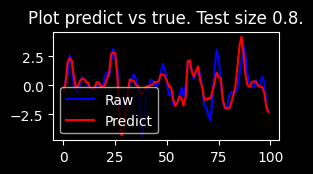

In [ ]:
for IDX,Train_Size in enumerate([0.8]):
    Training_range=[0,Train_Size]
    Testing_range=[Train_Size,Train_Size+(1-Train_Size)/2]
    Valid_range=[Train_Size+(1-Train_Size)/2,1]
    Training_set=NP.arange(NP.round(Training_range[0]*num_examples).astype(int)+bins_before,NP.round(Training_range[1]*num_examples).astype(int)-bins_after)
    Testing_set=NP.arange(NP.round(Testing_range[0]*num_examples).astype(int)+bins_before,NP.round(Testing_range[1]*num_examples).astype(int)-bins_after)
    Valid_set=NP.arange(NP.round(Valid_range[0]*num_examples).astype(int)+bins_before,NP.round(Valid_range[1]*num_examples).astype(int)-bins_after)

    #Get Training data
    X_Train=X[Training_set,:,:]
    X_flat_Train=X_flat[Training_set,:]
    Y_Train=Y[Training_set,:]

    #Get Testing data
    X_Test=X[Testing_set,:,:]
    X_flat_Test=X_flat[Testing_set,:]
    Y_Test=Y[Testing_set,:]

    #Get Validation data
    X_Valid=X[Valid_set,:,:]
    X_flat_Valid=X_flat[Valid_set,:]
    Y_Valid=Y[Valid_set,:]
    
    X_Train_mean=NP.mean(X_Train,axis=0)
    X_Train_std=NP.std(X_Train,axis=0)
    X_Train=(X_Train-X_Train_mean)/X_Train_std
    X_Test=(X_Test-X_Train_mean)/X_Train_std
    X_Valid=(X_Valid-X_Train_mean)/X_Train_std
    
    Y_Train_mean=NP.mean(Y_Train,axis=0)
    Y_Train=Y_Train-Y_Train_mean
    Y_Test=Y_Test-Y_Train_mean
    Y_Valid=Y_Valid-Y_Train_mean

    #Takes several minutes
    model_lstm=LSTMDecoder(units=400,dropout=0,num_epochs=5)
    model_lstm.fit(X_Train,Y_Train)
    Y_Valid_predicted_lstm=model_lstm.predict(X_Valid)


    #Get metric of fit
    #R2 is the pearson correlation, between our predicted and true values.
    #The closer to 1, the better the fit. Over 1 not possible, negative means inverse correlatiion. Coding bug.
    
    R2s_lstm=get_R2(Y_Valid,Y_Valid_predicted_lstm)
    print('R2s:', R2s_lstm)
    
    
    PLT.subplot(3,2,IDX+1)
    PLT.plot(Y_Valid[2000:2100,0]+Y_Train_mean[0],'b',label="Raw")
    PLT.plot(Y_Valid_predicted_lstm[2000:2100,0]+Y_Train_mean[0],'r',label="Predict")
    PLT.title(f"Plot predict vs true. Test size {Train_Size}.")
    PLT.legend()